 # Practice  Soft SVM.
 ----
  
  University : UTEC \\
  Course       : Machine Learning \\
  Professor    : Cristian López Del Alamo \\
  Topic        : Soft SVM \\
  Termina      : 4:45
   

 ----

Write the names and surnames of the members and the percentage of participation of each one in the development of the practice:
 - Integrante 1: Sofía Herrera (100%)
 - Integrante 2: Álvaro García (100%)
 - Integrante 3: Adrian Sandoval (100%)
 - Integrante 4: Elvis Lopez (25%)


 ----


  




In [ ]:
# Loading Libraries
!pip install pywavelets
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import cvxopt
import seaborn as sns
import itertools
import pywt
import os
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import zipfile
from skimage import io, color

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.8 MB/s eta 0:00:00


## Normalization

In [ ]:
# Data Normalizing
def normalizacion(data):
  min=np.min(data)
  max=np.max(data)
  data_norm=(data-min)/(max-min)
  return data_norm

## 1. Feature Vector

A wavelet is a more efficient method than Fourier transforms for approximating a non-periodic function. Since an image can be seen as a two-dimensional function in a 3D space, we can approximate it using wavelets. In this case, we use the Hard Wavelet. The goal is to obtain a characteristic vector that represents each image

[library:](https://pywavelets.readthedocs.io/en/latest/index.html)
----
Parámetros de la Función **haar**
- f: Image File Name
- n: Number of slider in the image

In [ ]:
# Wavelet function for extracting image characteristics. This function returns a vector with image characteristics
def haar(f, n):
  imagen = io.imread(f)
  for i in range(n):
    imagen, (LH, HL, HH) = pywt.dwt2(imagen, 'haar')
  gfg = np.array(imagen)
  return gfg.flatten()

### Encode Function
Encode is a function that encodes images into feature vectors using wavelets to extract relevant information from each image. Encode takes the path where the images are located, encodes them, and returns a matrix where the ith element of the matrix is the feature vector of image i.

In [ ]:
# This function loads all images in the specified path and returns a vector containing the feature vectors of these images. In the example, we use three splits.
def encode(path, cuts):
  encodings = []

  print("Ingresó : ")
  print(path)
  i=0
  for filename in os.listdir(path):
      image_file = os.path.join(path, filename)
      print(image_file)
      if os.path.isfile(image_file):
          encodings.append(haar(image_file, cuts))
      i=i+1
      if i==20:
        return encodings
  return encodings

## Loading the data and extracting features using Hard Wavelet

### get_data Function
This function takes as input the paths where images of happy and disgust people are located, encodes them, and stores them in matrices. One matrix contains rows with features of happy people and another matrix contains features of sad people; both are combined into the same matrix. The rows of the matrix are randomized to then create the database that will train our soft SVM

In [ ]:

def get_data(emotion_1, emotion_2, cuts):
  data  =  np.array(encode(emotion_1,cuts))
  data  = np.insert(data, 0, 1, axis=1)
  temp =  np.array(encode(emotion_2,cuts))
  temp = np.insert(temp, 0, -1, axis=1)
  data = np.concatenate((data, temp), axis=0)
  for i in range(10):
    np.random.shuffle(data)
  y = data[:,0]
  x = data[:, 1:]
  return x, y

# Load train and test data

We mount the drive in Colab, get the path where our images are located, and load the test and training data

[Download DataSet](https://drive.google.com/drive/folders/1TvgyPE5l6TWtx7Fa6ZSKVUG2SsvEvh7l?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#  In the variable path, write the path where your dataset is located
path = '/content/drive/MyDrive/images'

c1_emotion = 'fear'
c2_emotion = 'neutral'

c1_emotion_train  = path +  '/train/' + c1_emotion
c2_emotion_train  = path +  '/train/' + c2_emotion

c1_emotion_test  = path +  '/validation/' + c1_emotion
c2_emotion_test  = path +  '/validation/' + c2_emotion

train_x, train_y = get_data(c1_emotion_train, c2_emotion_train,1)
test_x, test_y = get_data(c1_emotion_test, c2_emotion_test,1)

Mounted at /content/drive
Ingresó : 
/content/drive/MyDrive/images/train/fear
/content/drive/MyDrive/images/train/fear/4149.jpg
/content/drive/MyDrive/images/train/fear/20876.jpg
/content/drive/MyDrive/images/train/fear/28593.jpg
/content/drive/MyDrive/images/train/fear/29069.jpg
/content/drive/MyDrive/images/train/fear/27565.jpg
/content/drive/MyDrive/images/train/fear/20396.jpg
/content/drive/MyDrive/images/train/fear/31904.jpg
/content/drive/MyDrive/images/train/fear/27850.jpg
/content/drive/MyDrive/images/train/fear/10568.jpg
/content/drive/MyDrive/images/train/fear/25203.jpg
/content/drive/MyDrive/images/train/fear/32357.jpg
/content/drive/MyDrive/images/train/fear/21683.jpg
/content/drive/MyDrive/images/train/fear/22438.jpg
/content/drive/MyDrive/images/train/fear/4319.jpg
/content/drive/MyDrive/images/train/fear/28648.jpg
/content/drive/MyDrive/images/train/fear/26294.jpg
/content/drive/MyDrive/images/train/fear/23286.jpg
/content/drive/MyDrive/images/train/fear/2270.jpg
/conten

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)



(40, 576)
(40,)
(40, 576)
(40,)


### 1. Hypothesis :  Remember, you can achieve it using linear algebra.

$h(x_i) = x_i*w^t + b$

In [ ]:
def h(X,w,b):
  return np.dot(X,w.T) +b


### 2. Loss function

$L = \frac{1}{2}\parallel W \parallel_2^2  + C\sum_{i=0}^nmax(0,1-y_i(x_iw^t + b)) $


In [ ]:
# Implemente la función de pérdida del soft SVM
def loss(y,y_aprox,W,C):
  return (1/2)*np.linalg.norm(W)**2 + C*(np.maximum(0,1-y*y_aprox))


### 3. Derivatives

1. iF ($y_i*h(x_i)) \lt 1 $
 - $\frac{\partial L}{\partial w} = w + C\sum_{
 i=0}^n-y_i*x_i $
2. else
 - $\frac{\partial L}{\partial w} = w $

----
**Don't forget to find the derivatives for Bias.**

$\frac{\partial L}{\partial b}= C*-y_i$






In [ ]:
# Implemente la función para obtener las derivadas de W
def derivatives(x, y,y_aprox, w, b, C):

  condition=y*y_aprox
  mask=condition<1

  #dw=w+ C*np.dot(-y_aprox,x)
  #db=C*y_aprox

  dw= w+ C*np.sum((-y[mask,np.newaxis]* x[mask]),axis=0)
  db=C*np.sum(-y[mask])
  return db,dw


### 4. Change Parameters


1. iF ($y_i*h(x_i)) \lt 1 $
 - $w  = w -  \alpha( C\sum_{
 i=0}^n-y_i*x_i) $
2. else
 - $w = w -  \alpha*w$

----
**Don't forget charge the Bias.**
$b= b - α* ∂b$


In [ ]:
def Update(x,y,y_aprox,w, b, db, dw, alpha,C):
  if (np.dot(y_aprox,h(x,w,b))<1):
    w=w-alpha*(C*np.dot(-y_aprox,x))
  else:
    w=w-alpha*dw
  b=b-alpha*db
  return w, b

# 5. Training stage

In [ ]:

def training(X, Y, C, alpha, epochs):
  w = np.array([np.random.rand() for i in range(X.shape[1])])
  b = np.random.rand()
  error = []
  for i in range(epochs):
    Y_aprox = h(X,w,b)
    db, dw = derivatives(X, Y,Y_aprox, w, b, C)
    w, b = Update(X,Y,Y_aprox,w, b, db, dw, alpha,C)
    L = loss(Y,Y_aprox,w,C)
    error.append(L)
  return w, b, error

### 6. Testing Stage

In [ ]:
# Implemente la función de testing
def testing(X,W,b):
  y_aprox = []
  # write your code here
  for i in range(X.shape[0]):
    y_aprox.append(np.sign(np.dot(X[i], W.transpose())+b))
  return np.array(y_aprox)

In [ ]:
# Main Program

m = train_y.size
k = train_x[0].size
train_x_norm = np.apply_along_axis(normalizacion, 1, train_x)
test_x_norm = np.apply_along_axis(normalizacion, 1, test_x)

train_x_norm = np.insert(train_x_norm, 0, 1, axis=1)
test_x_norm = np.insert(test_x_norm, 0, 1, axis=1)

W, b, e1, = training(train_x_norm, train_y, 1e6, 1e-8, 1200)
m = test_y.size
y_pred = testing(test_x_norm, W, b)
test_y = test_y.astype('int')
correct=np.count_nonzero(y_pred == test_y)

print("Clasificados correctamente:", correct)
print("Clasificados incorrectamente:", len(test_y)-correct)
print("% de efectividad", round(100*correct/len(test_y), 2))


Clasificados correctamente: 28
Clasificados incorrectamente: 12
% de efectividad 70.0


Let's plot the loss function through the epochs

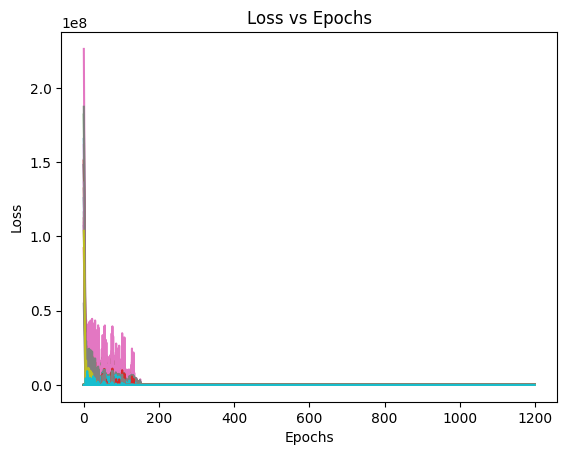

In [ ]:
plt.plot(e1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

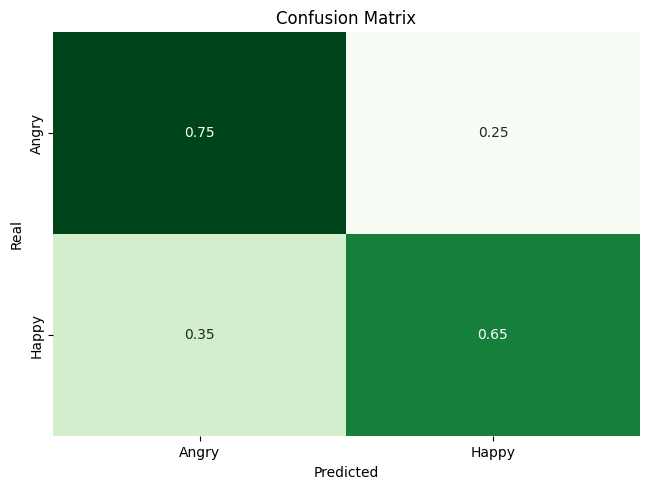

In [ ]:
matrix = confusion_matrix(test_y,y_pred)
df2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["Angry", 'Happy'], columns=["Angry", 'Happy'])
sns.heatmap(df2, annot=True, cbar=None, cmap="Greens")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

[Documento de excel](https://docs.google.com/spreadsheets/d/1yxYCjj_uS2Wrj8ofAc7hiRoCYX0-wJNiTMzGnWdsZoA/edit?usp=sharing)